## Explainer notebook

**Motivation**

* What is your dataset?
* Why did you choose this/these particular dataset(s)?
* What was your goal for the end user’s experience?

This project concerns itself with our derived dataset containing artists from pop and rap culture within North America. As music plays a significant role for most peoples lives including our’s it was naturally intriguing for us to delve down the path of music as soon as it was an option. Ideas sparked, and the question `Do rap and pop culture collaborate differently? If so, how?` served as a catalyst for our exploration.

We wanted to figure out how the structures in the networks of rap and pop are constructed and differ. What makes a community within rap and pop. Do rap and pop communities differ and what does that say about culture?

Wee initially found a dataset containing ~156.000 artists and ~300.000 discovered collaborators between artist A and B, i.e. artist A and B has produced at least one song together. The choice of network graph was natural from this point as artists are naturally nodes and edges are 1 if artist A and B worked together 0 if they have not. However, this dataset contained artists from all over the world and of any size. Therefore we derived a subset, which is further explained in the data section, that contains only relevant artists in North America within rap and pop genres. From here we could dive in and do our analysis.



Large dataset:

`https://www.kaggle.com/datasets/jfreyberg/spotify-artist-feature-collaboration-network?resource=download&fbclid=IwZXh0bgNhZW0CMTEAAR5jxk4FClm9GBFvCklV4Ga5SRwON3ajfqLdOMjFqN1uereEEduffCtjEbkjJg_aem_YUf8t7fIjwbCWiHS_vrVc`

Top 10k most listened us artists dataset:

`https://www.kaggle.com/datasets/spoorthiuk/us-top-10k-artists-and-their-popular-songs`

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import networkx as nx
import community as community_louvain
from collections import Counter, defaultdict
import netwulf as nw
import numpy as np
import re
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0 
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from scipy.stats import chi2
from nltk.tokenize import MWETokenizer
from wordcloud import WordCloud
import math
import pickle 

## Loading the datasets

In [2]:
nodes_df = pd.read_csv('nodes.csv')
edges_df = pd.read_csv('edges.csv')
nodes_df['genres'] = nodes_df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
nodes_df

,spotify_id,name,followers,popularity,genres,chart_hits
0,48WvrUGoijadXXCsGocwM4,Byklubben,1738.0,24,"[nordic house, russelater]",['no (3)']
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"[christlicher rap, german hip hop]","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ..."
2,652XIvIBNGg3C0KIGEJWit,Maxim,34596.0,36,[],['de (1)']
3,3dXC1YPbnQPsfHPVkm1ipj,Christopher Martin,249233.0,52,"[dancehall, lovers rock, modern reggae, reggae...","['at (1)', 'de (1)']"
4,74terC9ol9zMo8rfzhSOiG,Jakob Hellman,21193.0,39,"[classic swedish pop, norrbotten indie, swedis...",['se (6)']
...,...,...,...,...,...,...
156417,2ces6d2YsQP1RpGMYpdFy8,David Urwitz,5470.0,29,[classic swedish pop],NaN
156418,6AeznZajNbXUulT7W4tK5l,Darmiko,2022.0,23,[],NaN
156419,3GEijIjrgb4lPe9WtURBzz,Katriell,268.0,0,[],NaN
156420,0ldQL0icSoMz9OOZcWG8Zt,Yung Fresh,181.0,19,[],NaN


In [3]:
artists_us_df = pd.read_csv("most_listened_artists_in_US_dataset.csv", index_col=0)
artists_us_df

,ID,Gender,Age,Country,Genres,Popularity,Followers,URI
Name,,,,,,,,
Drake,3TVXtAsR1Inumwj472S9r4,male,33,CA,"['canadian hip hop', 'canadian pop', 'hip hop'...",95,83298497,spotify:artist:3TVXtAsR1Inumwj472S9r4
Post Malone,246dkjvS1zLTtiykXe5h60,male,25,US,"['dfw rap', 'melodic rap', 'pop', 'rap']",86,43130108,spotify:artist:246dkjvS1zLTtiykXe5h60
Ed Sheeran,6eUKZXaKkcviH0Ku9w2n3V,male,29,GB,"['pop', 'singer-songwriter pop', 'uk pop']",87,115998928,spotify:artist:6eUKZXaKkcviH0Ku9w2n3V
J Balvin,1vyhD5VmyZ7KMfW5gqLgo5,male,35,CO,"['reggaeton', 'reggaeton colombiano', 'trap la...",83,38028010,spotify:artist:1vyhD5VmyZ7KMfW5gqLgo5
Bad Bunny,4q3ewBCX7sLwd24euuV69X,male,26,PR,"['reggaeton', 'trap latino', 'urbano latino']",95,77931484,spotify:artist:4q3ewBCX7sLwd24euuV69X
...,...,...,...,...,...,...,...,...
IVAN$ITO,0cPmSFfjpop7imPVWSk2yc,NaN,0,NaN,[],20,4249,spotify:artist:0cPmSFfjpop7imPVWSk2yc
Antonello Venditti,3hYLJPJuDyblFKersEaFd6,male,71,IT,"[""canzone d'autore"", 'classic italian pop', 'i...",54,778642,spotify:artist:3hYLJPJuDyblFKersEaFd6
Lea Salonga,1GlMjIezcLwV3OFlX0uXOv,female,49,PH,"['movie tunes', 'tagalog worship']",56,179832,spotify:artist:1GlMjIezcLwV3OFlX0uXOv


In [4]:
artists_us_name_list = (artists_us_df.index).tolist()
print(artists_us_name_list[:5])

['Drake', 'Post Malone', 'Ed Sheeran', 'J Balvin', 'Bad Bunny']


## Finding the intersection betwen the two datasets

We will now be constructing our dataset as a intersection between the large spotify collaration dataset and `artists_us_name_list`

In [5]:
nodes_df = nodes_df[nodes_df["name"].isin(artists_us_name_list)]
nodes_df

,spotify_id,name,followers,popularity,genres,chart_hits
0,48WvrUGoijadXXCsGocwM4,Byklubben,1738.0,24,"[nordic house, russelater]",['no (3)']
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"[christlicher rap, german hip hop]","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ..."
15,3xs0LEzcPXtgNfMNcHzLIP,Rockwell,40344.0,58,[],"['us (1)', 'gb (1)', 'at (1)', 'be (1)', 'ca (..."
20,2NUz5P42WqkxilbI8ocN76,Vybz Kartel,1026598.0,63,"[dancehall, jamaican dancehall, reggae fusion]","['cr (3)', 'pa (1)']"
22,4Lm0pUvmisUHMdoky5ch2I,Apocalyptica,864846.0,60,"[alternative metal, bow pop, cello, finnish me...",['fi (2)']
...,...,...,...,...,...,...
156038,7p5J8SfKU9Rulp7tcA53G8,Jose Merce,182186.0,51,"[cante flamenco, flamenco, nuevo flamenco, rumba]",NaN
156119,3gJ0f9ov2Vjrbo9RnFFH76,Endor,267.0,2,[scottish indie folk],NaN
156199,7mKmqnXqn1WoEFljKyvAHR,2T FLOW,20.0,29,[],NaN
156220,6kT18gnkVrCz8xJQcrib7L,Bhaskar,230894.0,60,"[brazilian bass, brazilian edm, brazilian house]",NaN


By inspecting the dataframe, we notice there are more artists in the intersection than in the dataset containing the most listened artists in the US. This indicates there are duplicates in the dataset. We will inspect this:

In [6]:
duplicate_names = nodes_df[nodes_df.duplicated(subset="name", keep=False)].sort_values(by="name")

duplicate_names

,spotify_id,name,followers,popularity,genres,chart_hits
43592,1ItNxpDdetHb2gyS10HKfF,18 Karat,1644.0,18,[],NaN
13282,5oWFxbBrbk2Mw86PLUg3OZ,18 Karat,292544.0,53,"[deep german hip hop, german hip hop, german u...","['at (16)', 'de (30)', 'lu (3)', 'ch (12)']"
57139,09ZUMxxU5pgzUF0FtHeGXG,19HUNNID,5.0,1,[],NaN
59493,2Zm4abMQXwcrsM9IWY3AoB,19HUNNID,513.0,31,[thai trap],NaN
156199,7mKmqnXqn1WoEFljKyvAHR,2T FLOW,20.0,29,[],NaN
...,...,...,...,...,...,...
146823,1wEQjEpK6KfE9Et2ZZBfPa,Żabson,43.0,4,[],NaN
24780,0FtUnl4AjR5eDa1v77WU0b,ปู่จ๋าน ลองไมค์,138.0,17,[],NaN
95174,23YWwPEvaO5HLqEMgiUXJa,ปู่จ๋าน ลองไมค์,23424.0,32,[],NaN
6081,3dTgjg7lzUGiD3NwcGCK1n,阿冗,44494.0,48,"[chinese viral pop, mainland chinese pop]","['my (1)', 'sg (1)', 'tw (4)']"


As we can see, there are a large number of duplicate names. This is likely due to the size of the Spotify dataset, which contains more than 156,000 artists. It is also a consequence of spotify names which are not unique, meaning many small and  negligible artists are included in our dataframe. 

For example on spotify, consider the user `Drake`  who is in the top 10.000. Since the spotify names are not unique some negligible small spotify user could use the `Drake` name aswell and be included in our filtering process. To address this, we will apply a simple algorithm: for duplicate names, we will keep only the artist with the most Spotify followers.

In [7]:
final_cleaned_nodes_df = nodes_df.sort_values("followers", ascending=False)
final_cleaned_nodes_df = nodes_df.drop_duplicates(subset="name", keep="first")
final_cleaned_nodes_df

,spotify_id,name,followers,popularity,genres,chart_hits
0,48WvrUGoijadXXCsGocwM4,Byklubben,1738.0,24,"[nordic house, russelater]",['no (3)']
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"[christlicher rap, german hip hop]","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ..."
15,3xs0LEzcPXtgNfMNcHzLIP,Rockwell,40344.0,58,[],"['us (1)', 'gb (1)', 'at (1)', 'be (1)', 'ca (..."
20,2NUz5P42WqkxilbI8ocN76,Vybz Kartel,1026598.0,63,"[dancehall, jamaican dancehall, reggae fusion]","['cr (3)', 'pa (1)']"
22,4Lm0pUvmisUHMdoky5ch2I,Apocalyptica,864846.0,60,"[alternative metal, bow pop, cello, finnish me...",['fi (2)']
...,...,...,...,...,...,...
155870,3a9qv6NLHnsVxJUtKOMHvD,The Glitch Mob,538974.0,61,"[edm, electro house, glitch, glitch hop, indie...",NaN
156036,7dh6G6qILmRpUtZU4ZSD4D,Trobeats,515.0,9,[],NaN
156038,7p5J8SfKU9Rulp7tcA53G8,Jose Merce,182186.0,51,"[cante flamenco, flamenco, nuevo flamenco, rumba]",NaN
156220,6kT18gnkVrCz8xJQcrib7L,Bhaskar,230894.0,60,"[brazilian bass, brazilian edm, brazilian house]",NaN


Now, as we can see the intersection contains only 8756 rows (before 9754), meaning we succesfully removed 998 duplicate artists with the least amount of followers. We have now reached our final desired dataset

## Functions for constructing the desired networks:

In [8]:
def split_artists_by_genre(nodes_df, genre_names, exclusive=False):    
    nodes_df = nodes_df.copy()

    filtered_dfs = []

    for genre in genre_names:
        if exclusive:
            other_genres = [g for g in genre_names if g != genre]
            
            df = nodes_df[
                nodes_df['genres'].apply(
                    lambda genres: genre in ' '.join(genres) and all(other not in ' '.join(genres) for other in other_genres)
                )
            ].copy()
        else:
             df = nodes_df[
                nodes_df['genres'].apply(
                    lambda genres: genre in ' '.join(genres)
                )
            ].copy()
        
        filtered_dfs.append(df)

    return filtered_dfs

def get_Graph_with_names(nodes_df, edges_df, verbose=True):
    nodes_df = nodes_df.dropna(subset=['spotify_id', 'name'])
    edges_df = edges_df.dropna(subset=['id_0', 'id_1'])

    # Build ID to name map
    id_to_name = dict(zip(nodes_df['spotify_id'], nodes_df['name']))
    allowed_ids = set(id_to_name.keys())

    # Create graph with artist names as nodes
    G = nx.Graph()

    for _, row in nodes_df.iterrows():
        artist_name = row['name']
        followers = row['followers'] if not pd.isna(row['followers']) else 0
        popularity = row['popularity'] if not pd.isna(row['popularity']) else 0
        genres = row['genres']
        chart_hits = row['chart_hits'] if not pd.isna(row['chart_hits']) else []

        G.add_node(artist_name, followers=followers, popularity=popularity,
                   genres=genres, chart_hits=chart_hits)

    for _, row in edges_df.iterrows():
        id_0, id_1 = row['id_0'], row['id_1']
        if id_0 in allowed_ids and id_1 in allowed_ids:
            name_0 = id_to_name.get(id_0)
            name_1 = id_to_name.get(id_1)
            if name_0 and name_1:
                G.add_edge(name_0, name_1)

    if verbose:
        print(f"Number of nodes: {G.number_of_nodes()}")
        print(f"Number of edges: {G.number_of_edges()}")
        print(f"Network density: {nx.density(G)}")

    return G

def get_n_largest_component(G, n):
    return sorted(nx.connected_components(G), key=len, reverse=True)[n]

def apply_louvain(G, verbose=True):
    partition = community_louvain.best_partition(G)

    nx.set_node_attributes(G, partition, 'community')
    
    if verbose:
        community_sizes = Counter(partition.values())
        sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)
        for community_id, size in sorted_communities:
            print(f"Community {community_id}: {size} nodes")
    
    communities = defaultdict(list)
    for node, community_id in partition.items():
        communities[community_id].append(node)
    
    sorted_communities = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)
    return sorted_communities
        
def get_community_subgraph(G, community_id):
    nodes_in_community = [n for n, attr in G.nodes(data=True) if attr.get('community') == community_id]
    
    subgraph = G.subgraph(nodes_in_community).copy()
    
    return subgraph

def get_combined_louvain_splitted_graph(G):
    _G = G.copy()
    partition = community_louvain.best_partition(_G)
    nx.set_node_attributes(_G, partition, 'community')

    combined_G = nx.Graph()
    
    combined_G.add_nodes_from(_G.nodes(data=True))

    for u, v in _G.edges():
        if partition[u] == partition[v]:
            combined_G.add_edge(u, v, **_G[u][v])

    return combined_G

def print_top_collaborators(G, n):
    top_collaborators = sorted(G.degree, key=lambda x: x[1], reverse=True)[:n]

    print(f"Top {n} artists with the most collaborations:")
    for rank, (artist, degree) in enumerate(top_collaborators, start=1):
        print(f"{rank}. {artist} — {degree} collaborations")


In [9]:
pop_df, rap_df = split_artists_by_genre(final_cleaned_nodes_df, ["pop", "rap"])

len(pop_df), len(rap_df)

(4398, 1704)

In [11]:
print("---- Large Pop network: ----")
G_pop = get_Graph_with_names(pop_df, edges_df)
print("\n---- Large Rap network: ----")
G_rap = get_Graph_with_names(rap_df, edges_df)

---- Large Pop network: ----
Number of nodes: 4398
Number of edges: 17648
Network density: 0.0018252140370625595

---- Large Rap network: ----
Number of nodes: 1704
Number of edges: 11704
Network density: 0.008066405873093326


In [12]:
print_top_collaborators(G_rap, 5)

Top 5 artists with the most collaborations:
1. Ty Dolla $ign — 133 collaborations
2. Gucci Mane — 128 collaborations
3. French Montana — 124 collaborations
4. Future — 116 collaborations
5. Lil Wayne — 113 collaborations


In [14]:
print(print_top_collaborators(G_pop, 5))

Top 5 artists with the most collaborations:
1. R3HAB — 165 collaborations
2. Ty Dolla $ign — 141 collaborations
3. David Guetta — 135 collaborations
4. Snoop Dogg — 123 collaborations
5. Steve Aoki — 117 collaborations
None


In [16]:
G_rap_splittet = get_combined_louvain_splitted_graph(G_rap)

In [17]:
communities = apply_louvain(G_rap)
largest_community_id = communities[0][0]

G_largest_rap_community = get_community_subgraph(G_rap, largest_community_id)
G_largest_rap_community_splitted = get_combined_louvain_splitted_graph(G_largest_rap_community)

Community 2: 448 nodes
Community 5: 258 nodes
Community 1: 141 nodes
Community 14: 130 nodes
Community 11: 122 nodes
Community 9: 98 nodes
Community 27: 92 nodes
Community 16: 65 nodes
Community 7: 56 nodes
Community 67: 27 nodes
Community 21: 26 nodes
Community 22: 20 nodes
Community 4: 18 nodes
Community 35: 17 nodes
Community 12: 5 nodes
Community 54: 5 nodes
Community 83: 4 nodes
Community 119: 4 nodes
Community 31: 3 nodes
Community 42: 3 nodes
Community 113: 3 nodes
Community 149: 3 nodes
Community 47: 2 nodes
Community 90: 2 nodes
Community 91: 2 nodes
Community 112: 2 nodes
Community 123: 2 nodes
Community 3: 1 nodes
Community 6: 1 nodes
Community 10: 1 nodes
Community 13: 1 nodes
Community 15: 1 nodes
Community 17: 1 nodes
Community 18: 1 nodes
Community 20: 1 nodes
Community 24: 1 nodes
Community 25: 1 nodes
Community 26: 1 nodes
Community 28: 1 nodes
Community 29: 1 nodes
Community 30: 1 nodes
Community 32: 1 nodes
Community 33: 1 nodes
Community 34: 1 nodes
Community 36: 1 

## Visualzing the networks with `Netwulf`

In [21]:
# Visualize pop network

from Netwulf_plot_functions import netwulf_plot_communities
from community import community_louvain 

communities = community_louvain.best_partition(G_pop)

colors = ['#e57468', '#68e574', '#7468e5', '#e5d068', '#68d0e5']

netwulf_plot_communities(G_pop, communities, port=9981, color_palette=colors, path="Pop_network.pdf")

tmpgraph.json


TypeError: 'NoneType' object is not subscriptable

In [23]:
# Visualize rap network

from Netwulf_plot_functions import netwulf_plot_communities
from community import community_louvain 

communities = community_louvain.best_partition(G_rap)

colors = ['#e57468', '#68e574', '#7468e5', '#e5d068', '#68d0e5']

netwulf_plot_communities(G_rap, communities, port=9981, color_palette=colors, path="Rap_network.pdf")

tmpgraph.json


TypeError: 'NoneType' object is not subscriptable

## Network key statistics

In [24]:
from Network_statistics import print_network_statistics

In [25]:
print_network_statistics(G_pop)

Pop network statistics

Number of nodes: 4398
Number of edges: 17648
Density: 0.0018252140370625595
Number of isolated nodes: 736
Is connected: False
Number of connected components: 776
Size of largest component: 3551
Average shortest path length (largest component): 5.056972802741541
Average clustering coefficient: 0.14299548786390026
Transitivity (global clustering coefficient): 0.17630606849249938

Degree analysis
Average Degree: 8.03
Median Degree: 4.0
Mode Degree: 0
Minimum Degree: 0
Maximum Degree: 165


In [26]:
print_network_statistics(G_rap)

Pop network statistics

Number of nodes: 1704
Number of edges: 11704
Density: 0.008066405873093326
Number of isolated nodes: 146
Is connected: False
Number of connected components: 159
Size of largest component: 1500
Average shortest path length (largest component): 4.242214809873249
Average clustering coefficient: 0.26984041262185426
Transitivity (global clustering coefficient): 0.2903691218607787

Degree analysis
Average Degree: 13.74
Median Degree: 7.0
Mode Degree: 1
Minimum Degree: 0
Maximum Degree: 133


## Plotting degree distributions

In [27]:
from Network_statistics import plot_degree_distribution

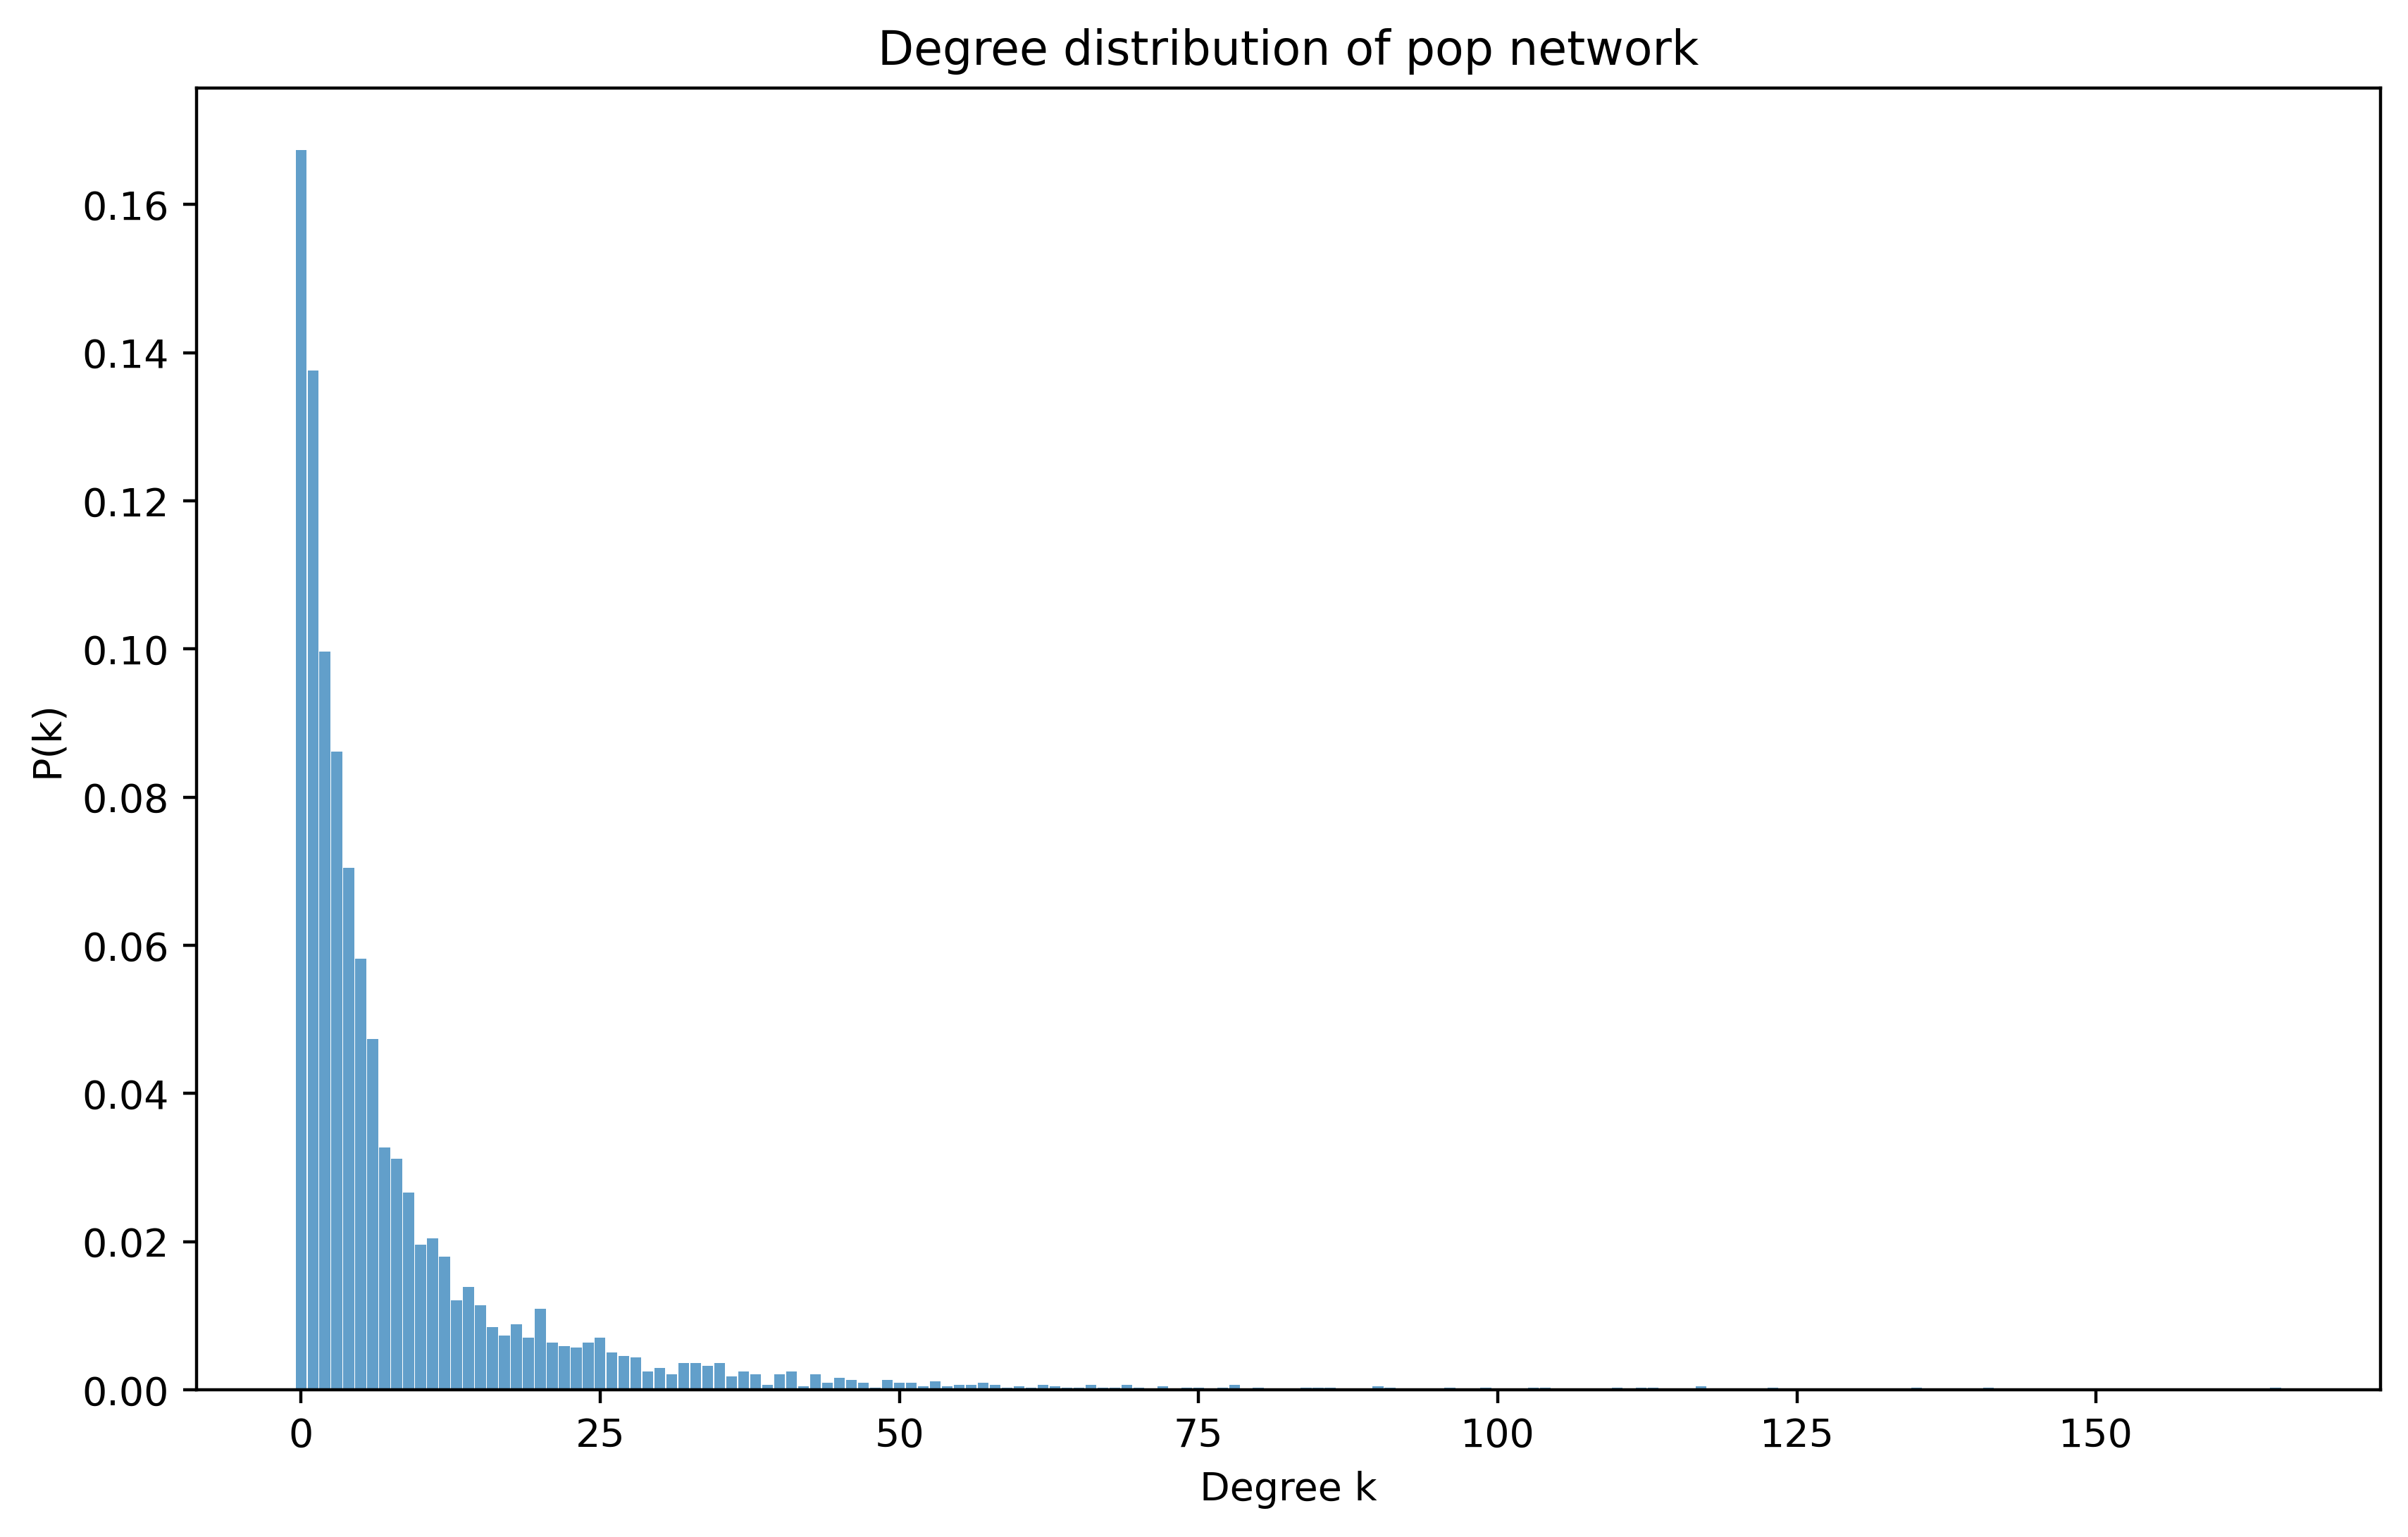

In [28]:
plot_degree_distribution(G_pop)

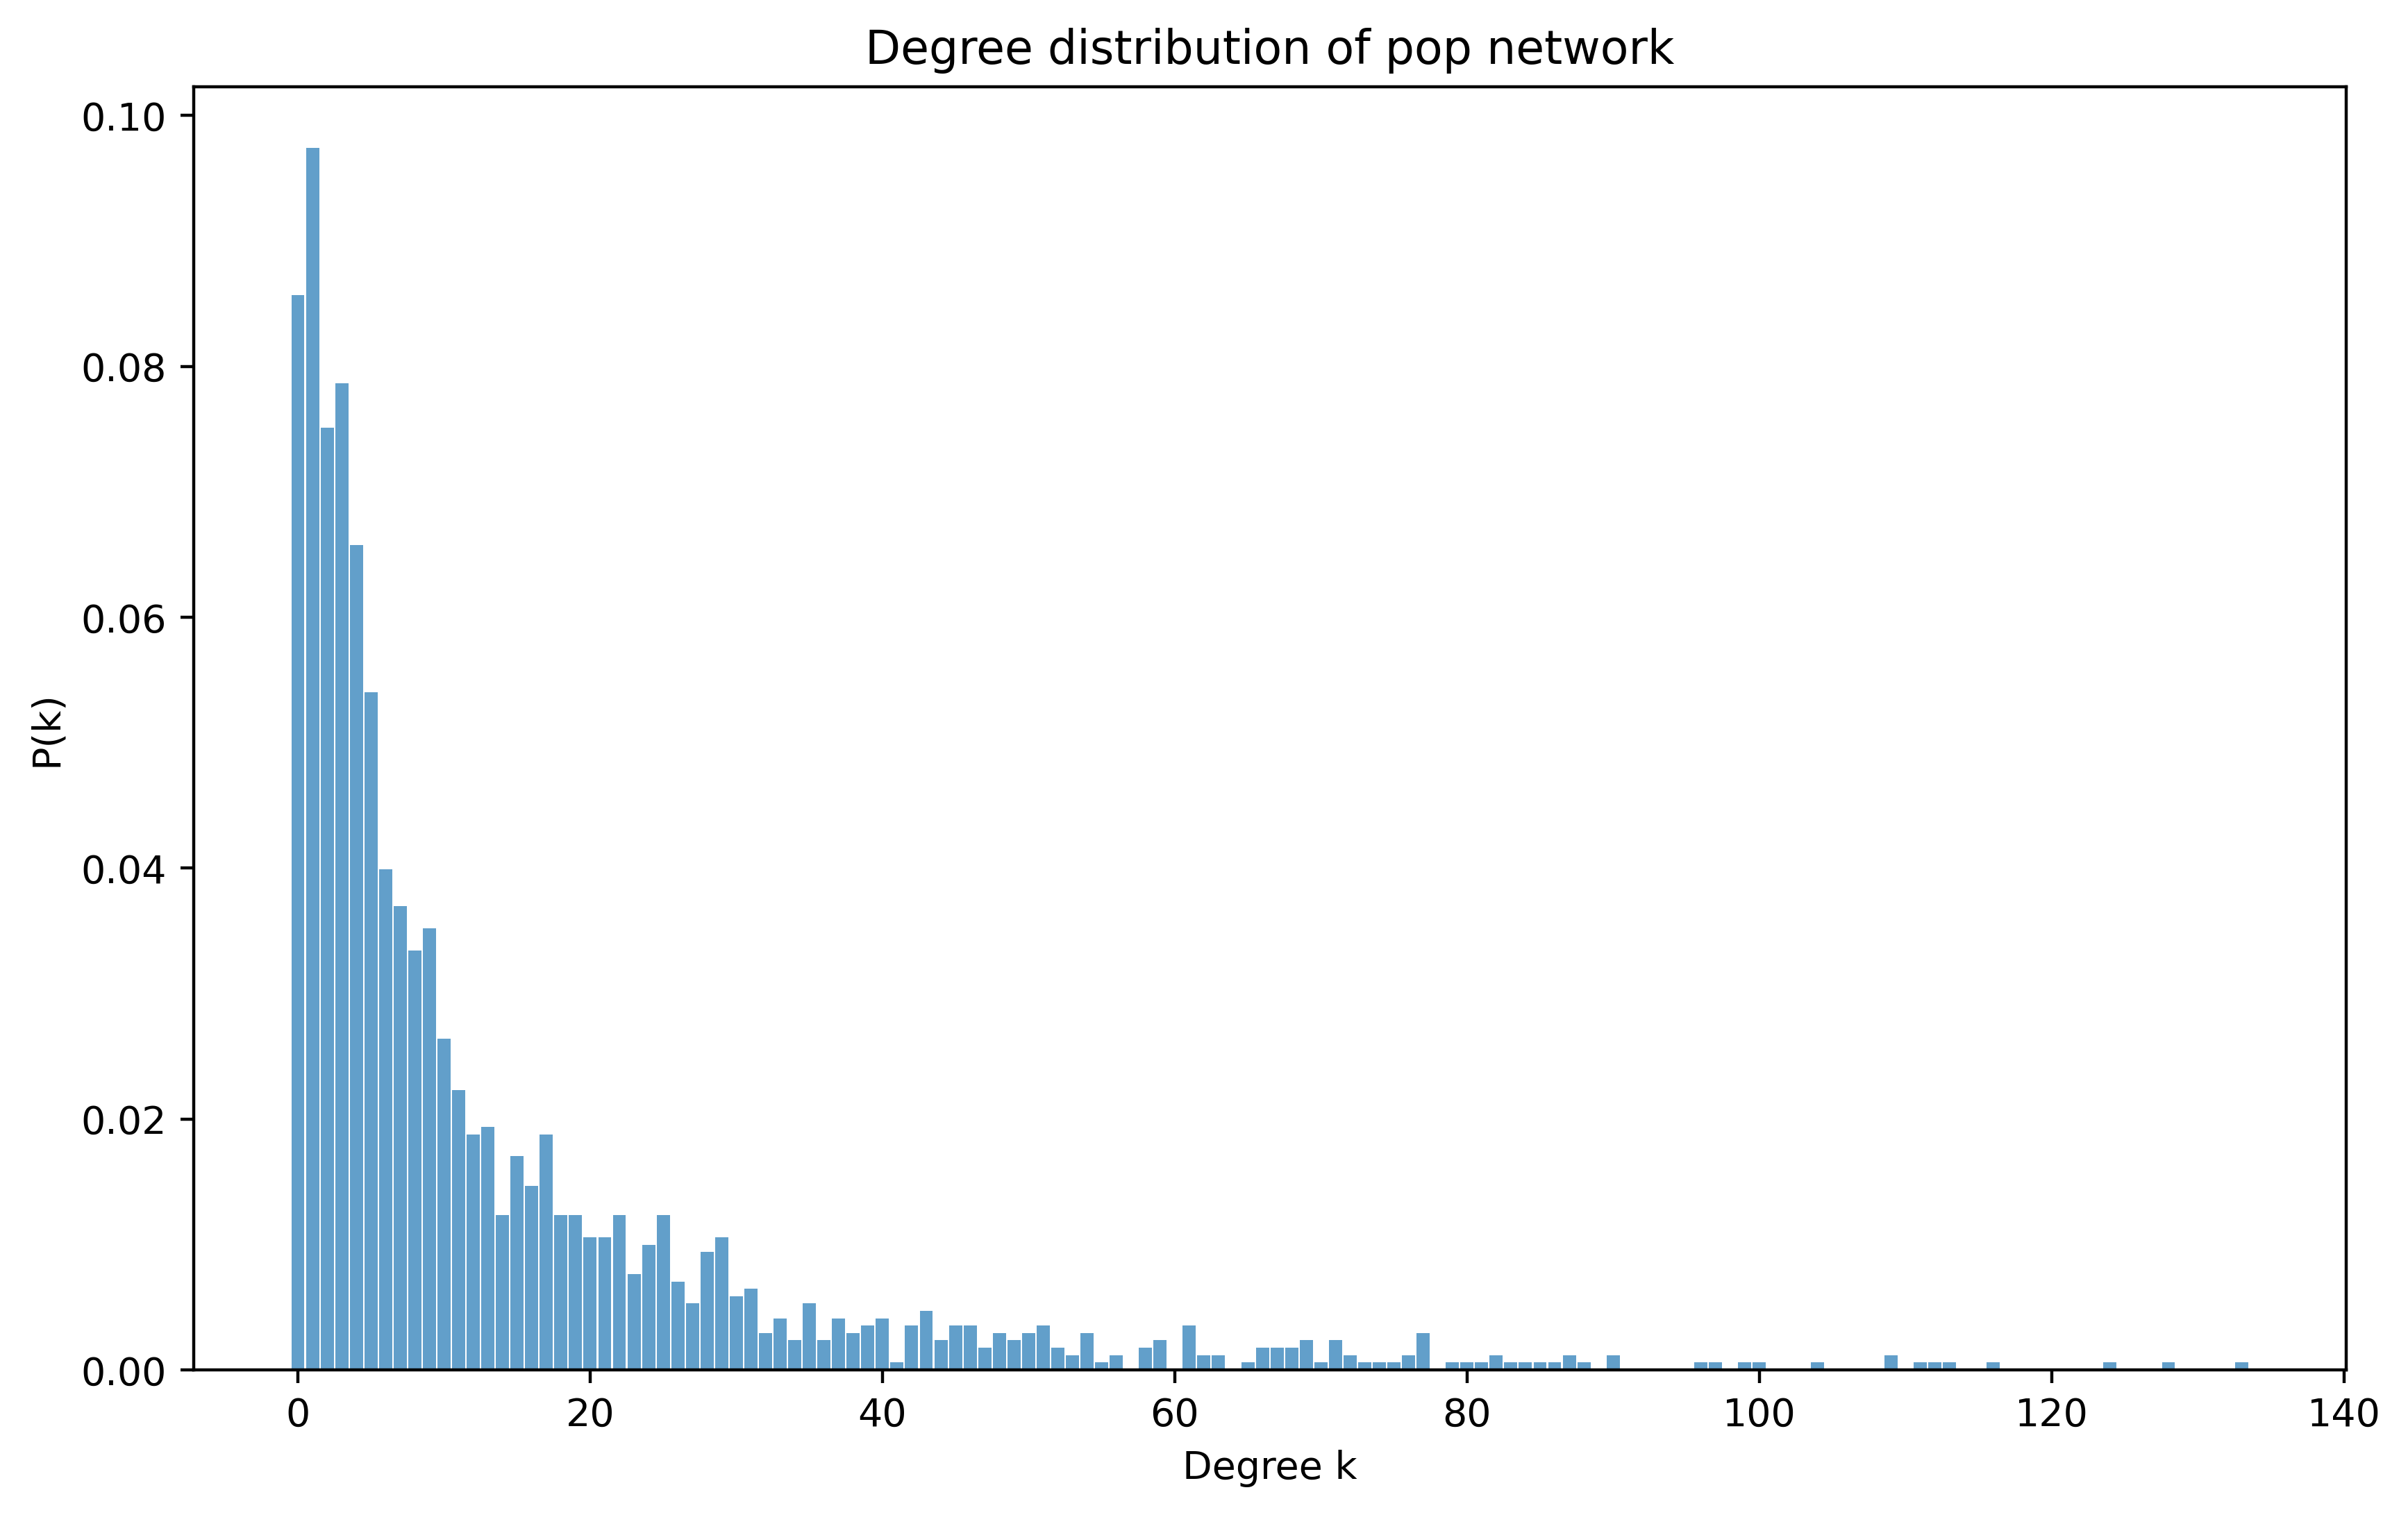

In [29]:
plot_degree_distribution(G_rap)

In [30]:
from Network_statistics import plot_degree_distribution_log_log_scale

Power-law exponent: 1.866


c:\Users\teisa\OneDrive\Skrivebord\DTU\semester 4\Computational Social Science\02467-Project-assignment\Network_statistics.py:85: RuntimeWarning: divide by zero encountered in power
  plt.plot(unique_degrees, C * unique_degrees ** gamma, 'k-', label=r'Power law $P(k) \sim k^{-\gamma}$')


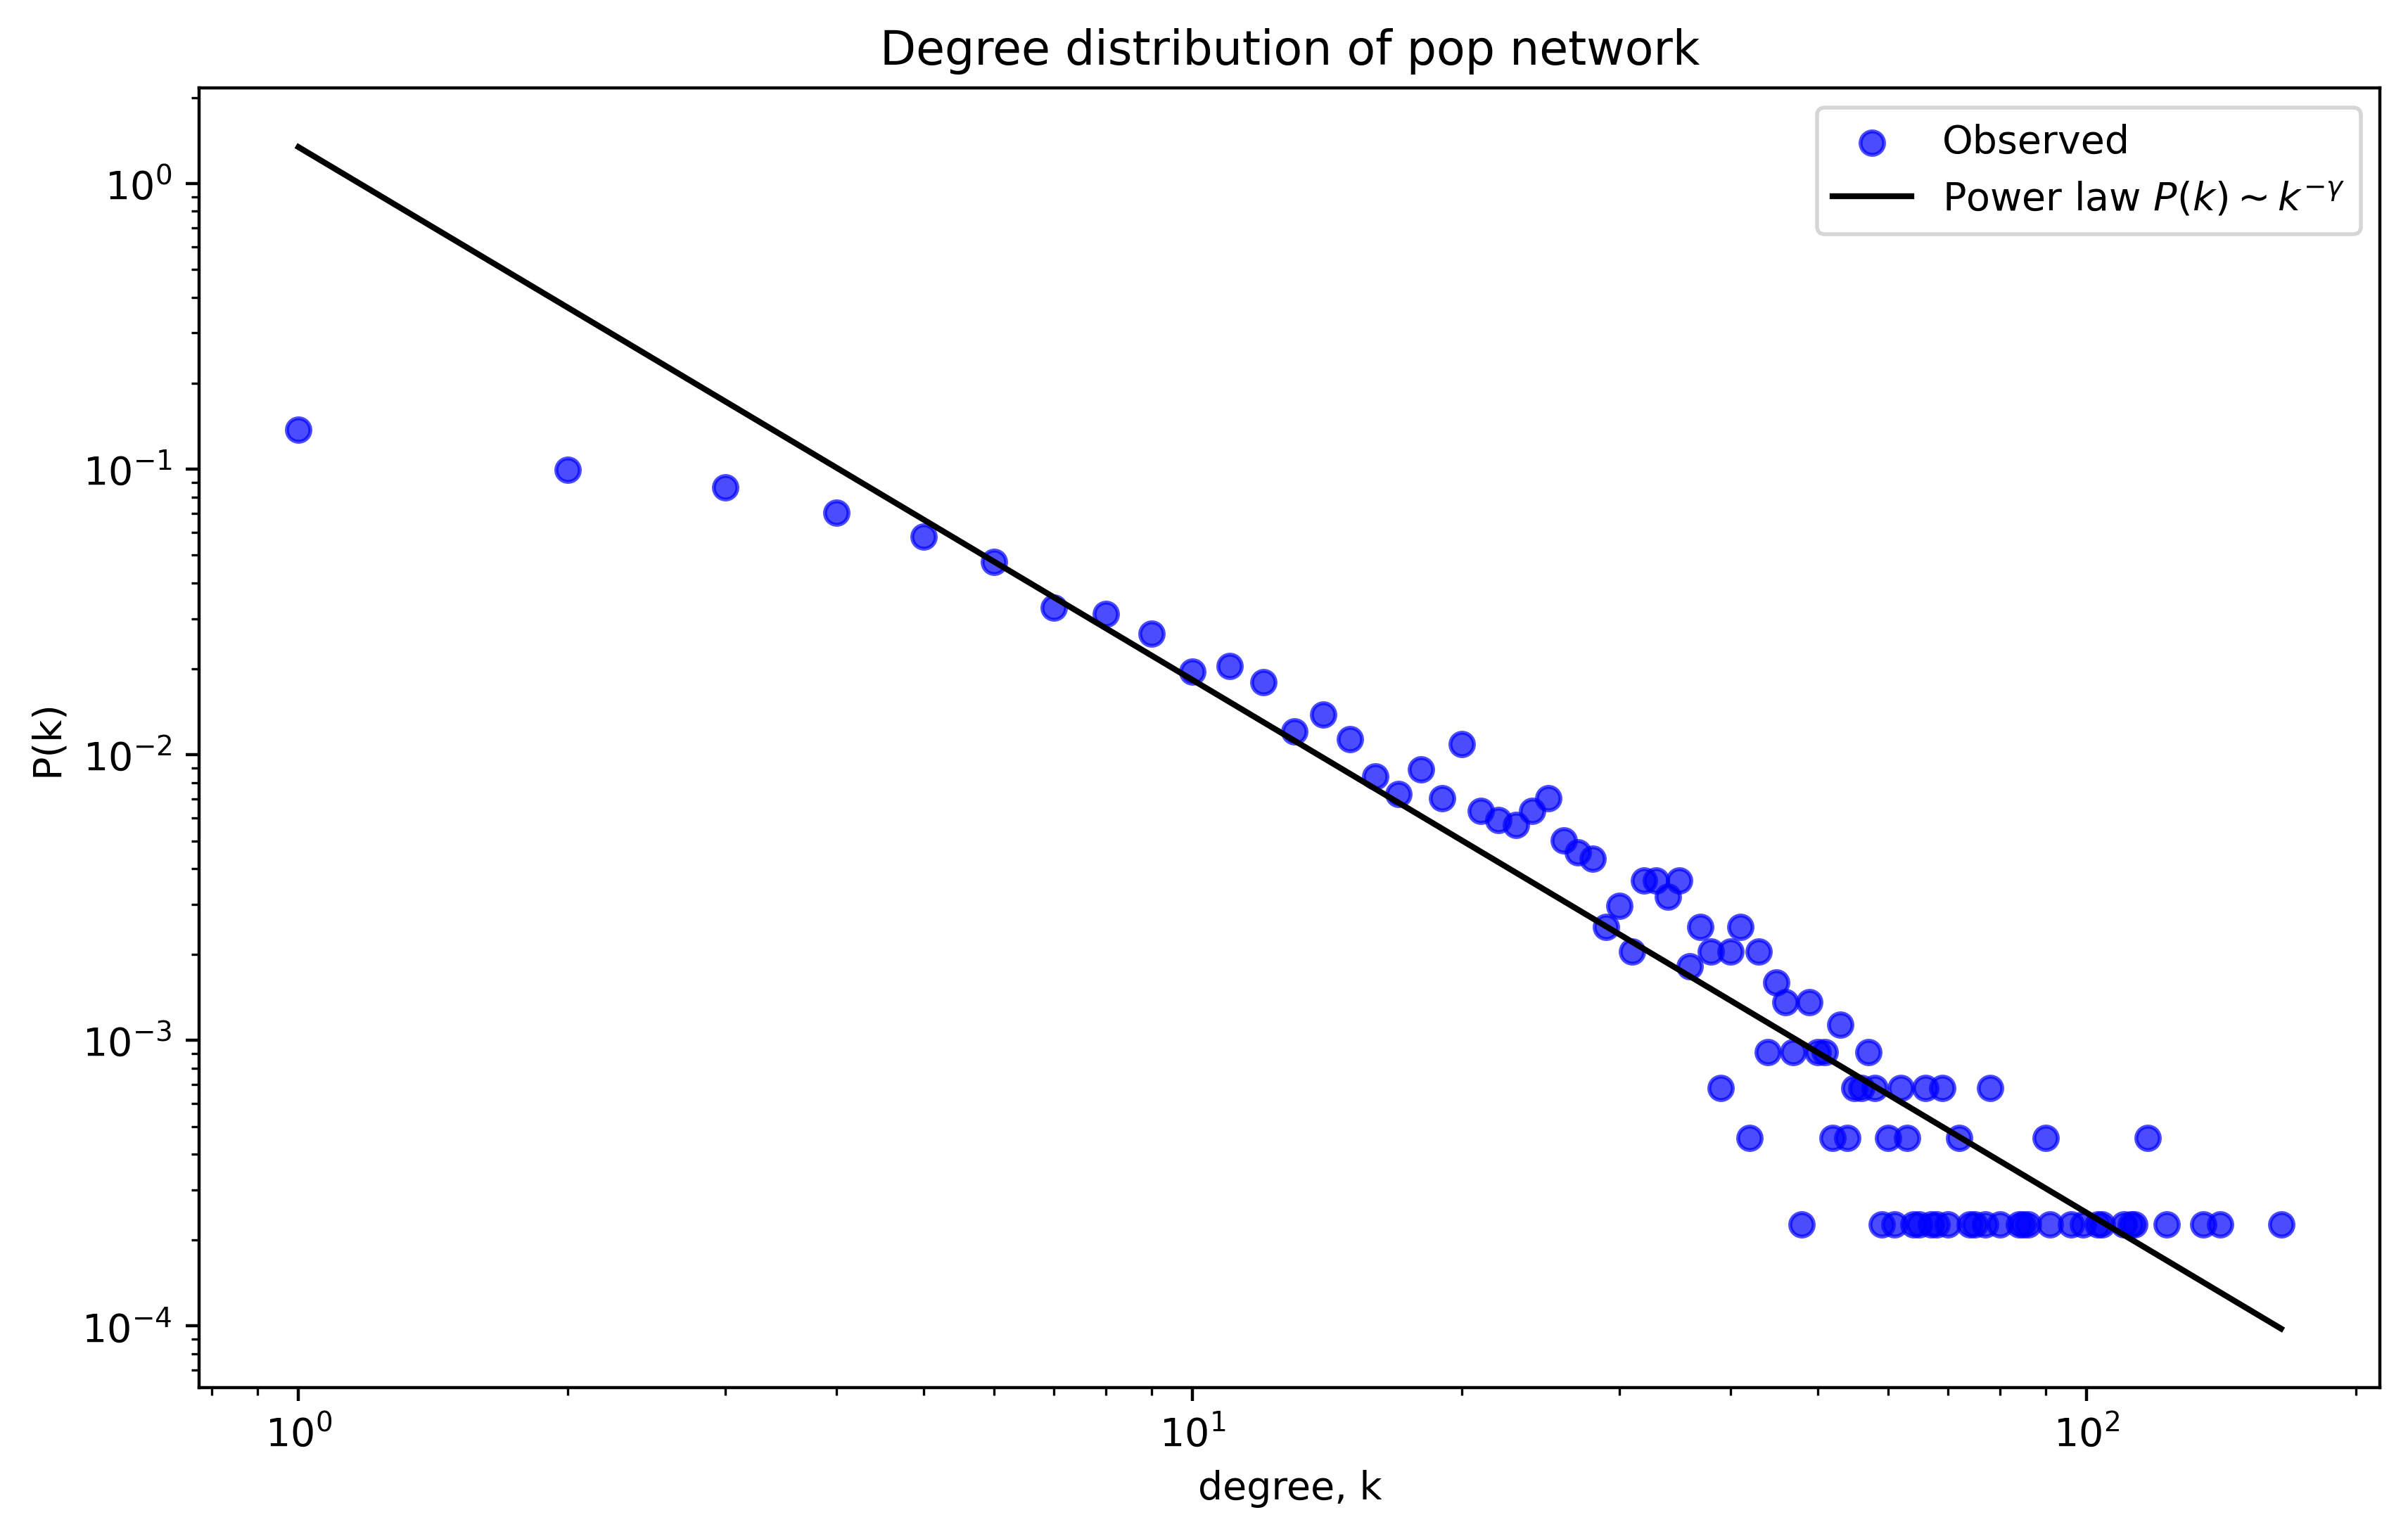

In [31]:
plot_degree_distribution_log_log_scale(G_pop)

Power-law exponent: 1.501


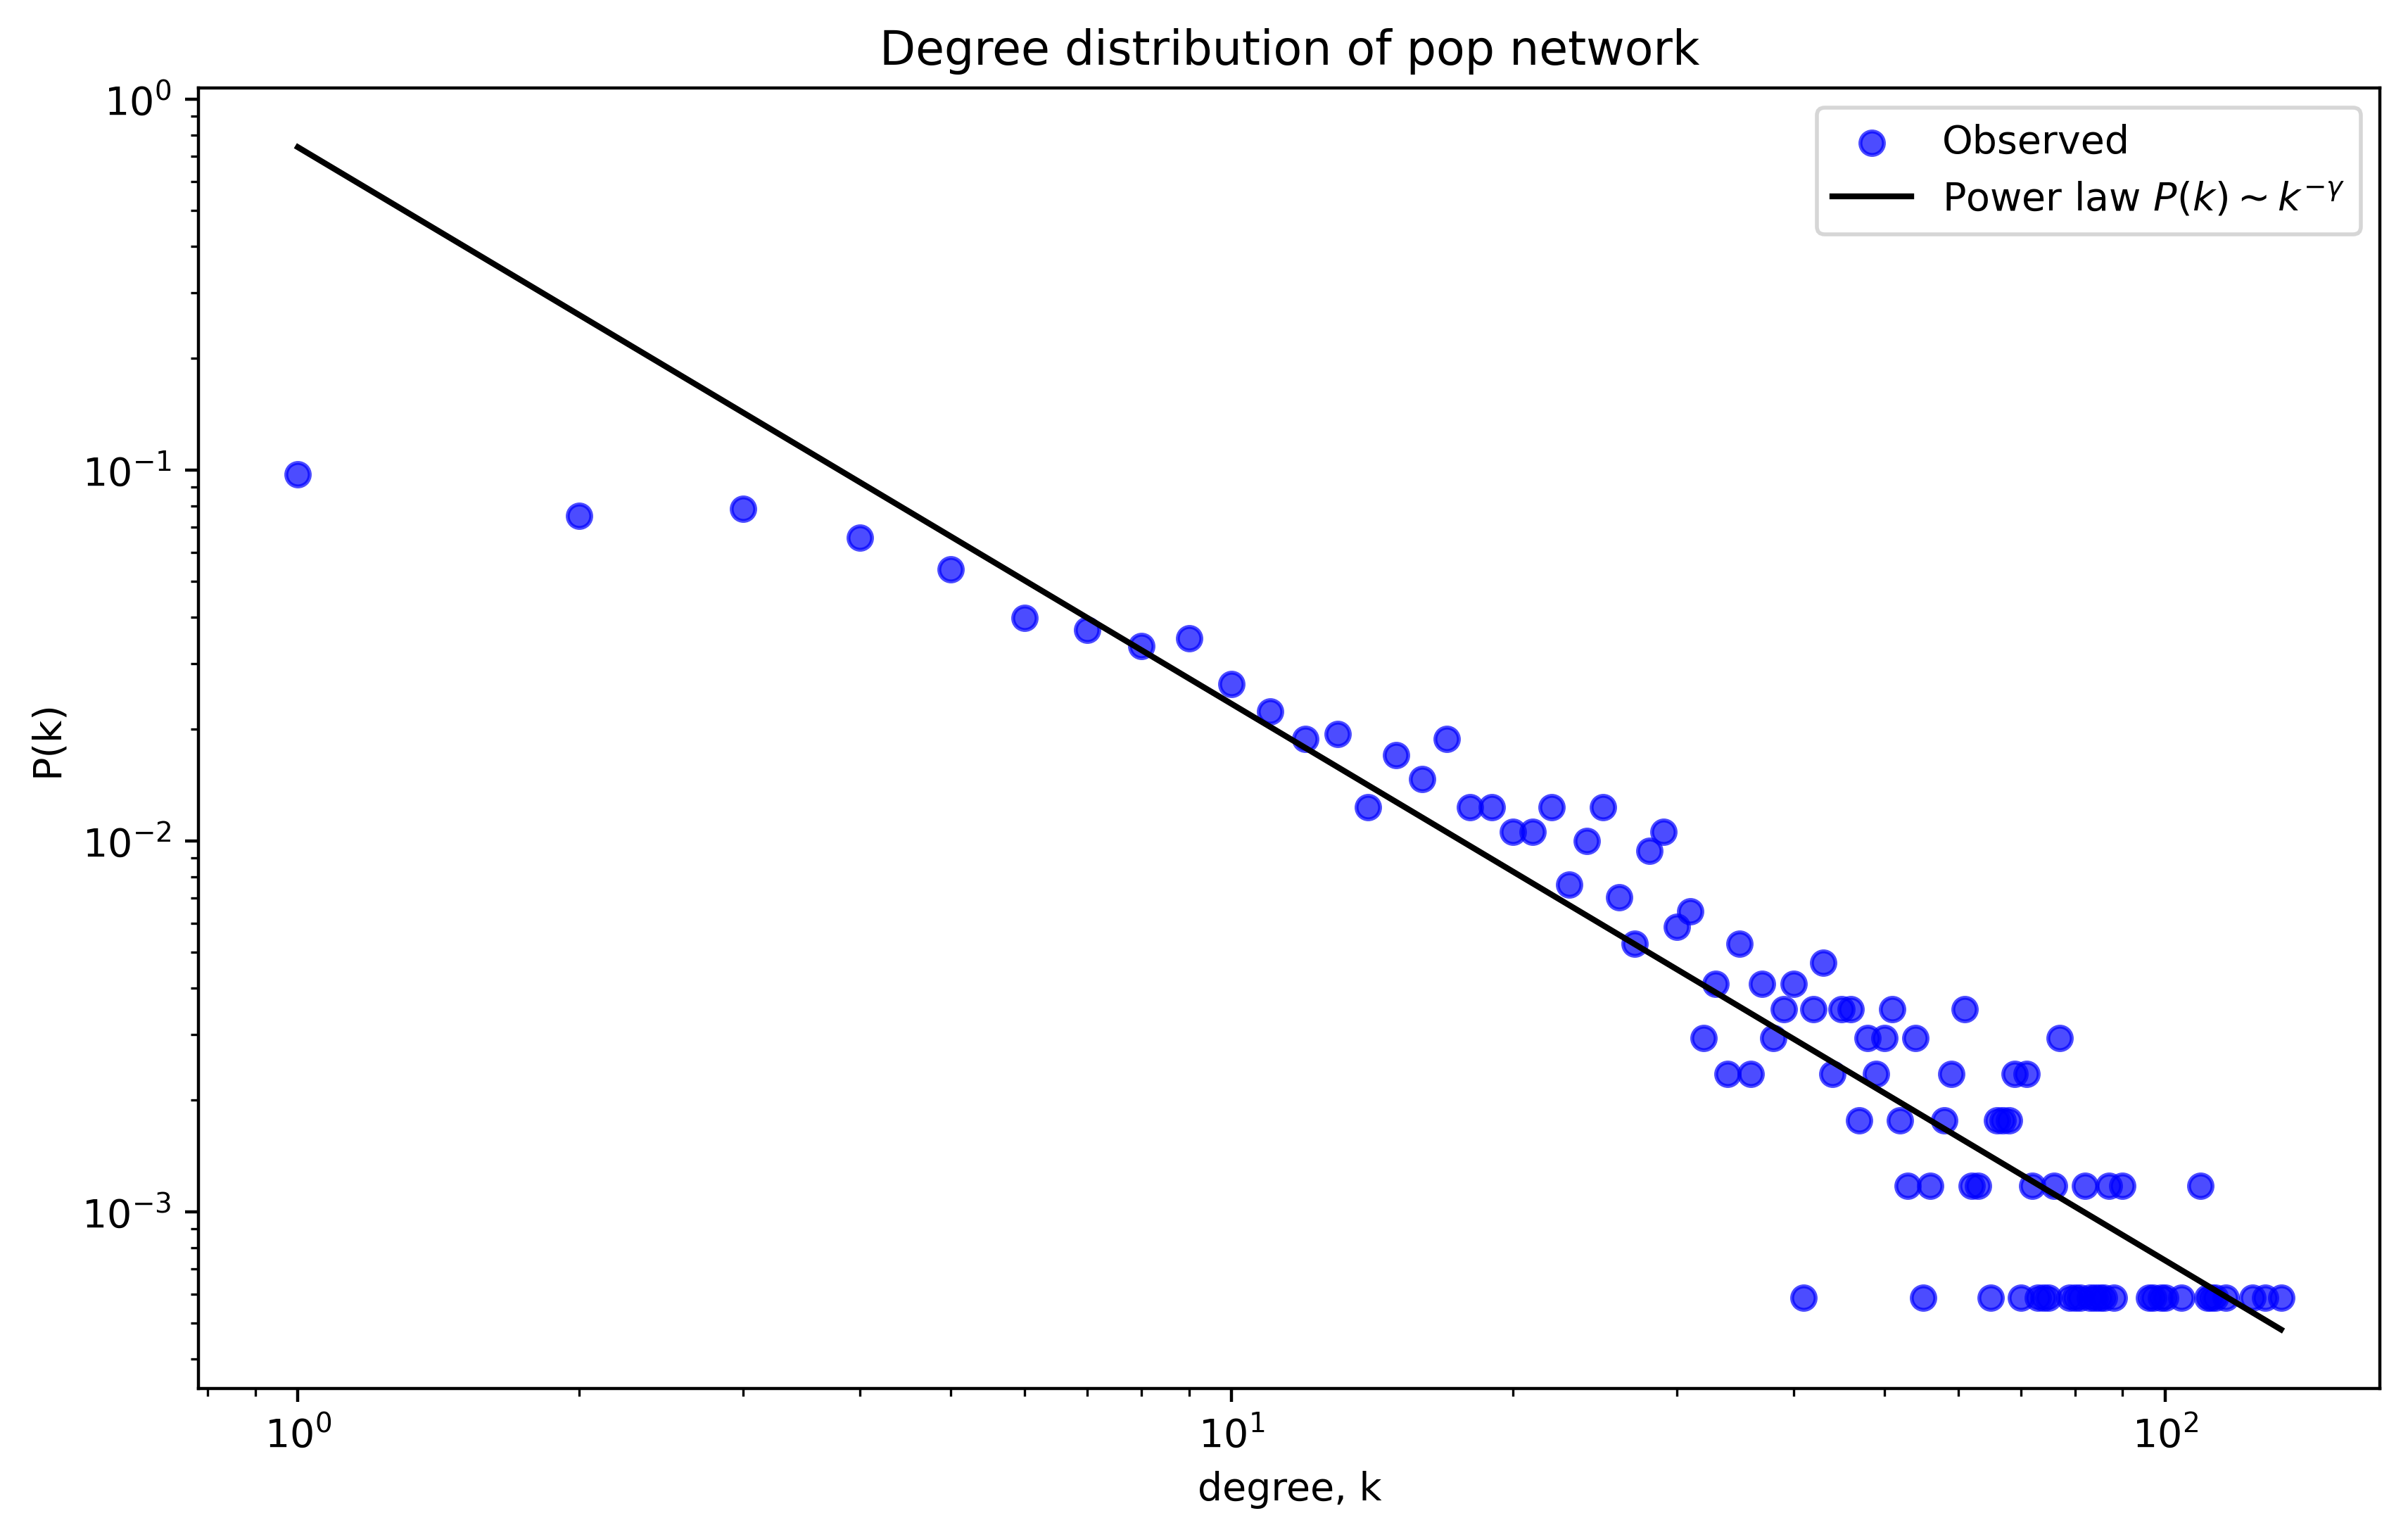

In [32]:
plot_degree_distribution_log_log_scale(G_rap)

## Text gathering

**Brug af Genius:**

# Text analsysis

**TF-IDF**

TF calculates the fraction of a term in a document.

$$TF(t,d) = \frac{f_{t,d}}{\sum_{t' \in d}(f_{t',d})}$$

where $f_{t,d}$ is the count of term $t$ in document $d$.

IDF is calculated as

$$
\text{IDF}(t, d) = \log \left( \frac{N}{\left| \left\{ d \in D \mid t \in d \right\} \right|} \right)
$$

where N is the count of documents in the entire corpus. and $ \left\{ d \in D \mid t \in d \right\} $ is the set of documents containing term t. $\left| \left\{ d \in D \mid t \in d \right\} \right|$ is then the count of documents containing the term t. Summarized IDF returns the log inverse fraction of documents containing the term t in the corpus D.

Combined as the product of the two they give the TF-IDF

$$TFIDF(t,d,D) = tf(t,d)\cdot idf(t,D)$$

This function combines a terms importance within a single document (its internal representation) with its overall significance across the corpus.

In [ ]:
# Replace with your actual file path
pop_artists_filename = "pop_df.pkl"

with open(pop_artists_filename, "rb") as file:
    pop_artists_df : pd.DataFrame = pickle.load(file)

# Replace with your actual file path
rap_artists_filename = "rap_df.pkl"

with open(rap_artists_filename, "rb") as file:
    rap_artists_df : pd.DataFrame = pickle.load(file)



In [282]:
class TextAnalysis():
    def __init__(self, artist_df : pd.DataFrame, G):
        self.orig_artist_df = artist_df.copy()
        self.artist_df = artist_df.copy()
        
        self.orig_artist_df.sort_values("followers", ascending=False, inplace=True)
        
        self.artist_df = self.artist_df.dropna()
        self.artist_df.sort_values("followers", ascending=False, inplace=True)
        
        self.G = G
        self.communities = community_louvain.best_partition(G)
        
        self.community_texts_df = None
        
    def clean_lyrics_and_apply_representative_text(self):
        def run(lyrics):
            cleaned = []
        
            for raw_lyrics in lyrics:
                # intro before "Read More\xa0\n"
                parts = raw_lyrics.split("Read More\xa0\n")
                lyrics = parts[-1] if parts else raw_lyrics

                # Remove first line often title/commentary
                lyrics_parts = lyrics.split('\n', 1)
                lyrics = lyrics_parts[1] if len(lyrics_parts) > 1 else lyrics_parts[0]

                # Remove [Verse], [Chorus], etc.
                lyrics = re.sub(r'\[.*?\]', '', lyrics)

                # Remove commentary
                lyrics = re.sub(r'^“.*?”\s*', '', lyrics)
                
                lyrics = re.sub(r'[^a-zA-Z\s]', '', lyrics)  # Only letters and spaces

                #Clean escaped characters and whitespace
                lyrics = re.sub(r'\\n|\\r|\r|\n', ' ', lyrics)
                lyrics = re.sub(r'\s+', ' ', lyrics).strip()
                
                lyrics = lyrics.lower()

                cleaned.append(lyrics)

            
            return " ".join(cleaned)
        
        self.artist_df["representative_text"] = self.artist_df["lyrics"].apply(run)
        
        return self.artist_df

    def filter_for_english_language(self):
        def is_english(text):
            try:
                return detect(text) == "en"
            except:
                return False

        self.artist_df["is_english"] = self.artist_df["representative_text"].apply(is_english)

        self.artist_df = self.artist_df[self.artist_df["is_english"]].reset_index(drop=True)

        print(f"Found {len(self.artist_df)} english artists")

        return self.artist_df

    def tokenize(self):
        stemmer = SnowballStemmer("english")
        stop_words = set(stopwords.words("english"))

        domain_stopwords = {"song", "lyrics", "chorus", "verse", "repeat"}

        stop_words = stop_words.union(domain_stopwords)

        print(f"Example stopwords {list(stop_words)[:5]}")
        
        def initial_tokenize(text):
            text = text.lower()
            words = re.findall(r'[a-zA-Z]+', text)
            return [stemmer.stem(word) for word in words if word not in stop_words]

        self.artist_df["tokens"] = self.artist_df["representative_text"].apply(initial_tokenize)

        all_tokens = [token for tokens in self.artist_df["tokens"] for token in tokens]

        finder = BigramCollocationFinder.from_words(all_tokens)
        finder.apply_freq_filter(51)

        bigram_measures = BigramAssocMeasures()
        scored = finder.score_ngrams(bigram_measures.chi_sq)

        collocations = []
        for bigram, score in scored:
            p_value = chi2.sf(score, df=1)
            if p_value < 0.001:
                collocations.append(bigram)

        mwe_tokenizer = MWETokenizer(collocations, separator="_")

        def retokenize(tokens):
            return mwe_tokenizer.tokenize(tokens)

        self.artist_df["tokens"] = self.artist_df["tokens"].apply(retokenize)

        return self.artist_df

    def prepare_community_texts(self):
        df = self.artist_df.copy()
        df["community"] = df["name"].map(self.communities)

        grouped = df.groupby("community")
        print(f"{len(grouped)} communities.")

        community_texts = grouped["tokens"].apply(lambda series: sum(series, [])).reset_index()
        community_texts["tokens_length"] = community_texts["tokens"].apply(len)

        self.community_texts_df = community_texts

        return community_texts

    def get_top_n_largest_community_ids(self, n):
        community_counts = Counter(self.communities.values()) # get the counts of each artist and commmunity pair
        
        sorted_by_counts = sorted(community_counts.items(), key=lambda x: x[1], reverse=True) # sort in descending by count.
        top_5_community_ids = np.array([id_and_count[0] for id_and_count in sorted_by_counts[:n]])

        return top_5_community_ids

    def __str__(self):
        names = self.artist_df["name"].head(5).tolist()
        return f"Top 5 artists: {', '.join(names)}"
    
    def __repr__(self):
        return self.__str__()
    
rap_text_analysis = TextAnalysis(rap_artists_df, G_rap)
pop_text_analysis = TextAnalysis(pop_artists_df, G_pop)

Cleaning of the lyrics and aggregating them into one comibned representative text

In [283]:
rap_text_analysis.clean_lyrics_and_apply_representative_text()

# rap_text_analysis.filter_for_english_language()

print(f"Example representative_text for artist '{rap_text_analysis.artist_df.iloc[0]['name']}': \n \n {rap_text_analysis.artist_df.iloc[0]['representative_text']}")

Example representative_text for artist 'Bad Bunny': 
 
 no quiero que m nadie me hable de amor ya me cans to eso truco ya me lo s eso dolore lo pas yeh yeh yeh no quiero que m nadie me hable de amor no no ya me cans to eso truco ya me lo s wuh eso dolore lo pas no no hoy te odio no e secreto ante todo lo confieso no si pudiera te pidiera que devuelva to los beso que te di la palabra y todo el tiempo que perd me arrepiento una y mil vece de haber confiao en ti wuh quisiera que te sienta como yo me siento siento quisiera ser como t sin sentimiento miento quisiera sacarte de mi pensamiento miento quisiera cambiarle el final al cuento toa la barra y lo trago han sido testigo del dolor que me causaste y to lo que hiciste conmigo un infeliz en el amor que an no te supera y que ahora camina solo sin nadie por toa la acera preguntndole a dios si en verdad el amor existe y por qu si yo era tan bueno toa esta mierda t me hiciste ciste lo m cabrn e que t ve todo como un chiste siempre voy a malde

In [284]:
rap_text_analysis.tokenize()

print(f"\n Example tokens for artist '{rap_text_analysis.artist_df.iloc[0]['name']}': \n \n {rap_text_analysis.artist_df.iloc[0]['tokens']}")

Example stopwords ['but', 'under', 'her', 'hasn', 's']

 Example tokens for artist 'Bad Bunny': 
 
 ['quiero_que', 'nadi', 'habl', 'de_amor', 'ya', 'can', 'eso', 'truco', 'ya_lo', 'eso', 'dolor', 'lo', 'pas', 'yeh_yeh', 'yeh', 'quiero_que', 'nadi', 'habl', 'de_amor', 'ya', 'can', 'eso', 'truco', 'ya_lo', 'wuh', 'eso', 'dolor', 'lo', 'pas', 'hoy', 'te', 'odio', 'e', 'secreto', 'ant', 'todo_lo', 'confieso', 'si', 'pudiera', 'te', 'pidiera', 'que', 'devuelva', 'los', 'beso', 'que_te', 'di', 'la', 'palabra', 'todo_el', 'tiempo_que', 'perd', 'arrepiento', 'una', 'mil', 'vece', 'de', 'haber', 'confiao', 'en_ti', 'wuh', 'quisiera', 'que_te', 'sienta', 'como_yo', 'siento', 'siento', 'quisiera', 'ser', 'como', 'sin', 'sentimiento', 'miento', 'quisiera', 'sacart', 'de_mi', 'pensamiento', 'miento', 'quisiera', 'cambiarl', 'el', 'final', 'al', 'cuento', 'toa_la', 'barra', 'lo', 'trago', 'han', 'sido', 'testigo', 'del', 'dolor', 'que', 'causast', 'lo_que', 'hicist', 'conmigo', 'un', 'infeliz', 'en_

In [285]:
rap_text_analysis.prepare_community_texts().head(5)

144 communities.


,community,tokens,tokens_length
0,2,"[hahahahaha, tank, god, ayi_ayi, ive, fuckin, ...",251857
1,3,"[mua, vituttaa, sun, naurus, mua, vituttaa, ku...",918
2,4,"[dealer, mix, ak, hezbollah, vip, deal, lambor...",4501
3,5,"[quiero_que, nadi, habl, de_amor, ya, can, eso...",294573
4,6,"[hey, where, drum, woo, ohohoh, let_go, ooh, g...",634


**Now we can aggregate a representative text for each community**

**Calculating TF values for tokens within the top 5 communities**

In [287]:
rap_top_5_community_ids = rap_text_analysis.get_top_n_largest_community_ids(5)
rap_top_5_communities = rap_text_analysis.community_texts_df[rap_text_analysis.community_texts_df["community"].isin(rap_top_5_community_ids)]

rap_top_5_communities

,community,tokens,tokens_length
0,2,"[hahahahaha, tank, god, ayi_ayi, ive, fuckin, ...",251857
3,5,"[quiero_que, nadi, habl, de_amor, ya, can, eso...",294573
9,11,"[jfume, des, gross, barr, jmtouff, il, mrest, ...",147045
12,14,"[ouai, faut, bien, quon, pens, plus, tard, che...",124908
20,23,"[ah, ankara, ayaz, ruhumu, keser, bi, cebimd, ...",140242


In [293]:
def get_TF_dataframe(communities_df):
    communities_df_expanded = communities_df.copy() # Copy top 5 communities to not make a mess
    exploded = communities_df_expanded.explode("tokens") # Explode into tokens

    token_counts  = exploded.groupby(["community", "tokens"]).size().reset_index(name="count")
    # group inside each community and get the token count store it in column "count"

    total_tokens = exploded.groupby("community").size().reset_index(name="total")
    # Group only by community such we can get the total counts

    tf_df = token_counts.merge(total_tokens, on="community") # Merge total_tokens onto token_counts so we can divide after and get the TF

    tf_df["TF"] = tf_df["count"] / tf_df["total"]
    
    return tf_df

def print_top_5_TF_per_community(tf_df):
    sorted_descending_by_tf = tf_df.sort_values(["TF"], ascending=[False]) # Sort it decending order by TF such term with highest TF is up.
    top_5_per_community = sorted_descending_by_tf.groupby("community").head(5).reset_index()
    # Grouping by community to then get the 5 largest by .head(5) as they are sorted descendingly. Finnaly reshaping back using reset_index.

    top_5_per_community_sorted = top_5_per_community.sort_values(["community"]) # sort such we get the terms 
    # for each community next to each other. Easier when printing

    print(f"{len(top_5_per_community_sorted)} terms")

    for i in range(0,len(top_5_per_community_sorted),5):
        print(f"Community: {top_5_per_community_sorted.iloc[i]["community"]}, 5 Terms: {top_5_per_community_sorted[i: i+5]["tokens"].to_list()}")

rap_tf_df = get_TF_dataframe(rap_top_5_communities)

print_top_5_TF_per_community(rap_tf_df)

25 terms
Community: 2, 5 Terms: ['im', 'like', 'nigga', 'got', 'yeah']
Community: 5, 5 Terms: ['que', 'de', 'la', 'te', 'el']
Community: 11, 5 Terms: ['la', 'pas', 'le', 'les', 'de']
Community: 14, 5 Terms: ['je', 'ik', 'het', 'de', 'die']
Community: 23, 5 Terms: ['ich', 'und', 'die', 'bi', 'bu']


In [290]:
def get_IDF_dataframe(community_texts):
    community_texts_expanded = community_texts.copy() # Copy the community text to not make a mess
    exploded = community_texts_expanded.explode("tokens") # Explode into tokens

    print(f"{len(exploded)} tokens...")

    community_token_pairs = exploded[["community", "tokens"]].drop_duplicates() 
    # Removing all duplicates as we just need to know if community i has token j.

    token_to_community_count = community_token_pairs.groupby("tokens").size().reset_index(name="tokenInCommunityCount") 
    # Count how many communities the token exists in.

    N = len(community_texts)

    IDF_df = token_to_community_count
    IDF_df["idf"] = np.log(N / IDF_df["tokenInCommunityCount"])

    return IDF_df
    
rap_IDF_df = get_IDF_dataframe(rap_text_analysis.community_texts_df)

rap_IDF_df.head()

1468077 tokens...


,tokens,tokenInCommunityCount,idf
0,aa,14,2.330756
1,aaa,4,3.583519
2,aaaa,3,3.871201
3,aaaaa,1,4.969813
4,aaaaaa,1,4.969813


In [291]:
def get_TF_IDF_dataframe(tf_df, IDF_df):
    tf_idf_df = tf_df.copy().merge(IDF_df[["tokens", "idf"]], on="tokens", how="left") # Merge the idf_values onto each token in tf_df. 
    # To prepare for calculating the tf-idf value.

    tf_idf_df["tf-idf"] = tf_idf_df["TF"] * tf_idf_df["idf"]

    return tf_idf_df

rap_TF_IDF_df = get_TF_IDF_dataframe(rap_tf_df, rap_IDF_df)

rap_TF_IDF_df.head()

,community,tokens,count,total,TF,idf,tf-idf
0,2,aa,3,251857,0.000012,2.330756,0.000028
1,2,aaa,1,251857,0.000004,3.583519,0.000014
2,2,aaaa,1,251857,0.000004,3.871201,0.000015
3,2,aaaaaaaaaalcohol,5,251857,0.000020,4.969813,0.000099
4,2,aaaaaalcohol,13,251857,0.000052,4.969813,0.000257


In [292]:
def print_top_10_tf_idf_tokens(tf_idf_df):
    sorted_descending_by_tf_idf = tf_idf_df.sort_values(["tf-idf"], ascending=[False]) # Sort it decending order by 'tf-idf' such term with 
    # highest tf-idf is furthest up.
    top_10_per_community = sorted_descending_by_tf_idf.groupby("community").head(10).reset_index()
    # Grouping by community to then get the 10 largest using .head(10) as they are sorted descendingly. Finnaly reshaping back using reset_index.

    top_10_per_community_sorted = top_10_per_community.sort_values(["community"]) # sort such we get the terms 
    # for each community next to each other. Easier when printing

    print(f"{len(top_10_per_community_sorted)} terms")

    for i in range(0, len(top_10_per_community_sorted), 10):
        print(f"Community: {top_10_per_community_sorted.iloc[i]["community"]}, 10 Terms: {top_10_per_community_sorted[i: i+10]["tokens"].to_list()}")

print("---Rap---")        
print_top_10_tf_idf_tokens(rap_TF_IDF_df)

---Rap---
50 terms
Community: 2, 10 Terms: ['got', 'like', 'nigga', 'bitch', 'aint', 'shit', 'get', 'im', 'know', 'gon']
Community: 5, 10 Terms: ['de', 'el', 'la', 'que', 'lo', 'en_la', 'los', 'pero', 'pa', 'te']
Community: 11, 10 Terms: ['jsui', 'des', 'et', 'les', 'pas', 'jai', 'le', 'cest', 'de', 'la']
Community: 14, 10 Terms: ['jij', 'een', 'maar', 'ze', 'je', 'het', 'mn', 'ik', 'niet', 'ik_ben']
Community: 23, 10 Terms: ['bi', 'nicht', 'die', 'und', 'ich', 'der', 'ist', 'bu', 'auf', 'mein']


In [197]:
def get_community_to_top_3_artists(top_5_communities, artist_community_dict, degrees_dict):
    community_to_top_3_artists = defaultdict(list) # initialise default dict.

    for community in top_5_communities["community"]: # loop each community
        comunity_authors = [author for author, _community in artist_community_dict.items() if _community == community] 
        # filter authors for given community
        sorted_authors_by_degree = sorted(comunity_authors, key=lambda x: degrees_dict[x], reverse=True) 
        # sort authors in descending order by their degrees using degrees_dict
        community_to_top_3_artists[community] = sorted_authors_by_degree[:3] # store top 3 for later
        print(f"The top 3 authors by degree in community {community} are with ids: {', '.join(sorted_authors_by_degree[:3])}") # print top 3
        
    return community_to_top_3_artists

print("---Rap---")
rap_community_to_top_3_artists = get_community_to_top_3_artists(rap_top_5_communities, rap_artist_to_community, rap_degrees_dict)

print("---Pop---")
pop_community_to_top_3_artists = get_community_to_top_3_artists(pop_top_5_communities, pop_artist_to_community, pop_degrees_dict)

---Rap---
The top 3 authors by degree in community 0 are with ids: Ty Dolla $ign, Gucci Mane, French Montana
The top 3 authors by degree in community 1 are with ids: Massaka, Anıl Piyancı, Azzi Memo
The top 3 authors by degree in community 4 are with ids: Farruko, De La Ghetto, Myke Towers
The top 3 authors by degree in community 10 are with ids: Lacrim, Jul, Naps
The top 3 authors by degree in community 14 are with ids: Jonna Fraser, Bizzey, Adje
---Pop---
The top 3 authors by degree in community 1 are with ids: R3HAB, David Guetta, Steve Aoki
The top 3 authors by degree in community 6 are with ids: Juan Magán, Becky G, Sebastian Yatra
The top 3 authors by degree in community 9 are with ids: Petter, Cherrie, Faustix
The top 3 authors by degree in community 13 are with ids: Lacrim, Soprano, Dadju
The top 3 authors by degree in community 15 are with ids: Ty Dolla $ign, Snoop Dogg, French Montana


In [200]:
def get_community_to_top_n_by_followers(top_communities_df, artist_to_community, artist_df, n=3):
    community_to_top_3 = defaultdict(list)

    for community_id in top_communities_df["community"]:
        # Find all artist names in this community
        community_artists = [
            artist for artist, comm_id in artist_to_community.items()
            if comm_id == community_id
        ]

        # Filter artist_df to include only those artists
        community_artist_df = artist_df[artist_df["name"].isin(community_artists)]

        # Sort by followers
        sorted_df = community_artist_df.sort_values(by="followers", ascending=False)

        # Get top 3 artists
        top_artists = sorted_df["name"].head(n).tolist()
        community_to_top_3[community_id] = top_artists

        print(f"Top {n} artists by followers in community {community_id}: {', '.join(top_artists)}")

    return community_to_top_3

n=3

rap_community_to_top_3_artists = get_community_to_top_n_by_followers(rap_top_5_communities, rap_artist_to_community, orig_rap_artists_df, n)
pop_community_to_top_3_artists = get_community_to_top_n_by_followers(pop_top_5_communities, pop_artist_to_community, orig_pop_artists_df, n)


Top 3 artists by followers in community 0: Drake, Eminem, Post Malone
Top 3 artists by followers in community 1: Ezhel, Sagopa Kajmer, Ceza
Top 3 artists by followers in community 4: Bad Bunny, J Balvin, Ozuna
Top 3 artists by followers in community 10: Jul, Damso, Soolking
Top 3 artists by followers in community 14: Djadja & Dinaz, Lil Kleine, Inkonnu
Top 3 artists by followers in community 1: Ed Sheeran, Taylor Swift, BTS
Top 3 artists by followers in community 6: Shakira, Sebastian Yatra, Camilo
Top 3 artists by followers in community 9: M83, Lukas Graham, Roxette
Top 3 artists by followers in community 13: Ninho, Sfera Ebbasta, Niska
Top 3 artists by followers in community 15: Ariana Grande, Billie Eilish, Drake


In [201]:
def plot_wordcloud(tf_idf_df, top_communities, community_to_top_3_authors, n=100):

    # Sort by tf-idf score descending
    sorted_descending_by_tf_idf = tf_idf_df.sort_values("tf-idf", ascending=False)

    # Get top-n per community
    top_n_per_community = (
        sorted_descending_by_tf_idf.groupby("community").head(n).reset_index(drop=True)
    )

    # Sort by community number
    top_n_per_community_sorted = top_n_per_community.sort_values("community")

    print(f"{len(top_n_per_community_sorted)} terms")

    num_communities = len(top_communities)
    cols = 3  # You can change this default
    rows = math.ceil(num_communities / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten()

    for idx, community in enumerate(top_communities["community"]):
        top_words_df = top_n_per_community_sorted[
            top_n_per_community_sorted["community"] == community
        ]
        word_freq = dict(zip(top_words_df["tokens"], top_words_df["tf-idf"]))

        authors = community_to_top_3_authors.get(community, [])
        author_str = "\n".join(authors)

        wc = WordCloud(width=800, height=600, background_color="white").generate_from_frequencies(word_freq)

        axes[idx].imshow(wc, interpolation="bilinear")
        axes[idx].set_title(f"Community {community}\n\n{author_str}", fontsize=14, pad=20)
        axes[idx].axis("off")

    # Turn off any extra axes (if grid > number of communities)
    for j in range(num_communities, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

500 terms


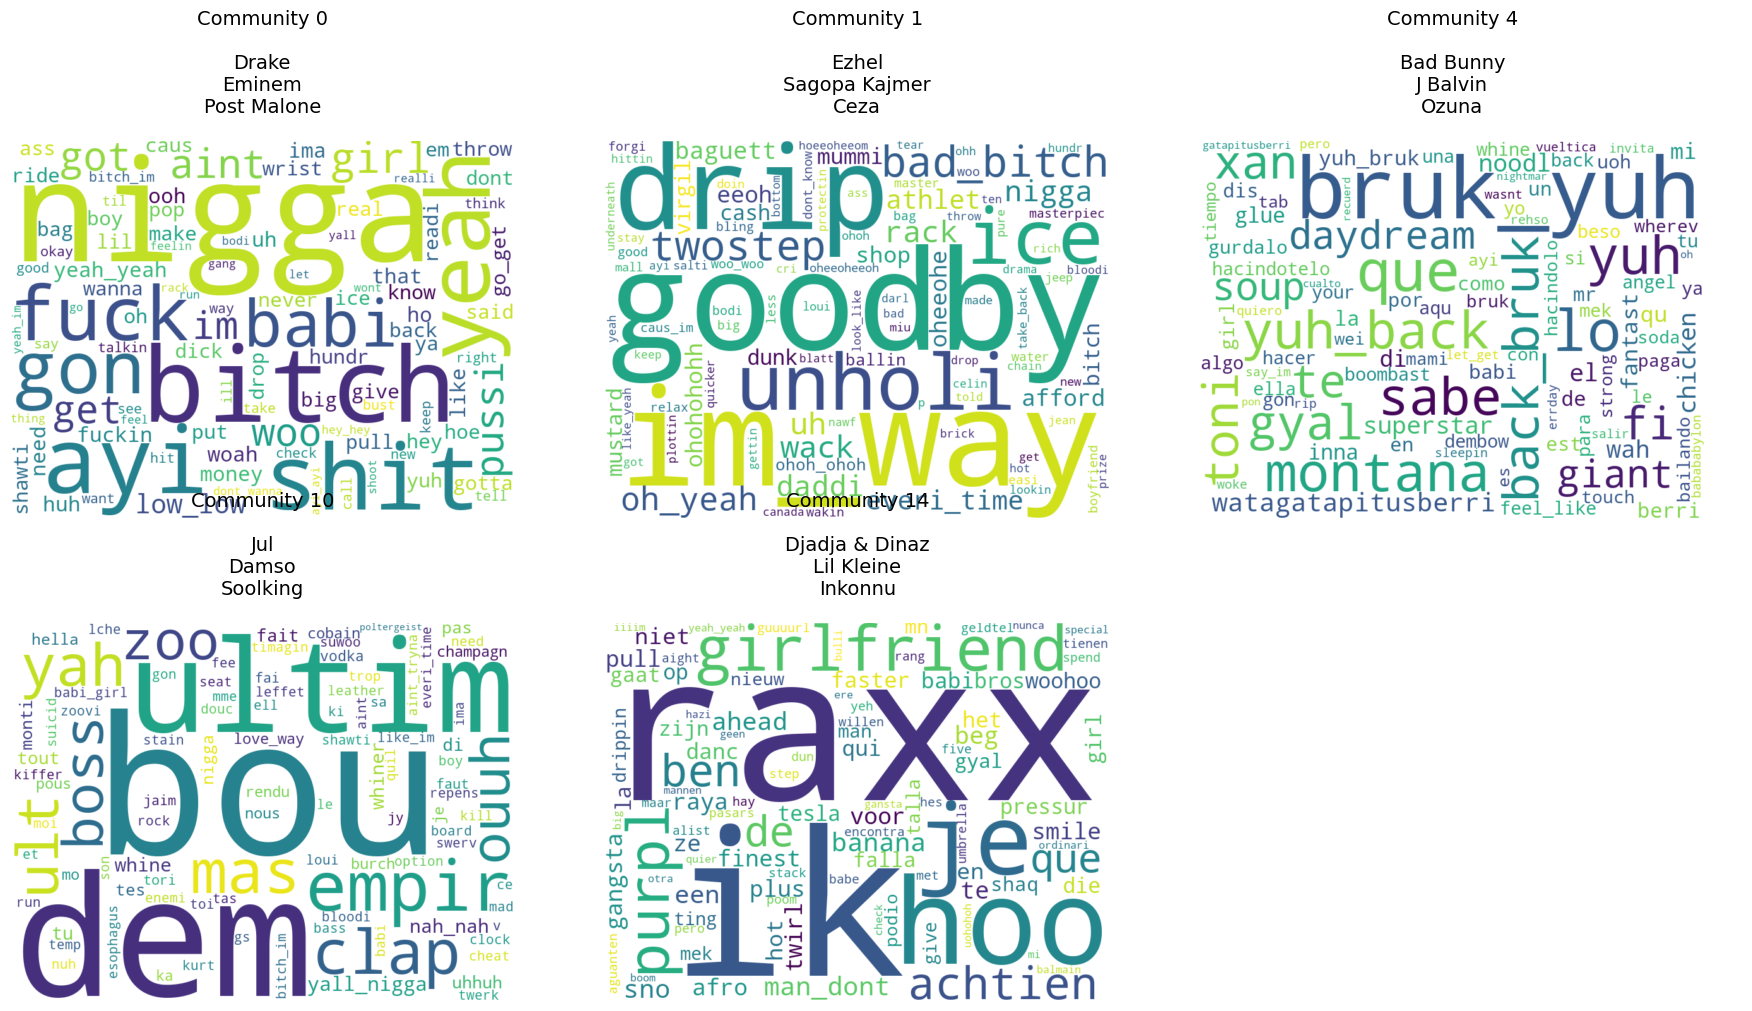

In [202]:
plot_wordcloud(rap_TF_IDF_df, rap_top_5_communities, rap_community_to_top_3_artists)